In [2]:
import jmespath
import pandas as pd
import matplotlib.pyplot as plt
from wetb.gtsdf import gtsdf
import warnings
import os
import re
#import functions
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

from windio_converter.io import HAWC2_dict
from windio_converter.io import HTC_dict

plt.style.use("COWI")
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [3]:
# Specify location for each set of result files.

folder1 = "C:/CRPO/02_Running_area/DTU_Thesis/0_Local_testing/Manual_conversion_IEA15MW/HAWC2/IEA-15-240-RWT-UMaineSemi" # always a Baseline model
folder2 = "C:/CRPO/02_Running_area/DTU_Thesis/0_Local_testing/WINDIO_conversion_IEA15MW_v03/IEA15MW_Floating_v03"
#folder2 = "./WINDIO_conversion_IEA15MW_adjMSYS/IEA15MW_Floating" #always windio model
#figure_directory = "0_Figures/Test01"
file1 = "1_1_1_15MW_UMaineSemi_Fix_rotor_Wo_ctrl_steady_3ms"
file2 = "1_1_1_15MW_Floating_Fix_rotor_Wo_ctrl_steady_3ms"
figure_directory = "0_Figures/model_data/07032025_v03WINDIO"

# Functions

In [4]:
# Function to create directory if it doesn't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [5]:
iea15_H2_1 = HAWC2_dict().read_hawc2(folder1, "htc/%s.htc"%file1)
iea15_H2_dict1 = iea15_H2_1.copy()
iea15_H2_2 = HAWC2_dict().read_hawc2(folder2, "htc/%s.htc"%file2)
iea15_H2_dict2 = iea15_H2_2.copy()

In [6]:

def parse_dat_file(filename):
    body_data = {}
    current_body = None
    
    with open(filename, 'r') as file:
        lines = iter(file.readlines())  # Use iterator to read lines sequentially
        
        for line in lines:
            # Detect a new body section
            body_match = re.match(r"Body data for body number\s*:\s*\d+\s*with the name\s*:(\S+)", line)
            if body_match:
                current_body = body_match.group(1)  # Extract body name (e.g., "main_column")
                body_data[current_body] = {}  # Initialize storage for this body
                continue
            
            if current_body:
                # Extract specific fields
                if "Body initial position" in line:
                    body_data[current_body]["initial_position"] = list(map(float, re.findall(r"-?\d+\.\d+E[+-]?\d+", line)))
                elif "Body initial velocity" in line:
                    body_data[current_body]["initial_velocity"] = list(map(float, re.findall(r"-?\d+\.\d+E[+-]?\d+", line)))
                elif "Body mass" in line:
                    body_data[current_body]["mass"] = float(re.search(r"-?\d+\.\d+E[+-]?\d+", line).group())
                elif "Body inertia" in line:
                    # Extract inertia values from the next line
                    next_line = next(lines).strip()
                    body_data[current_body]["inertia"] = list(map(float, re.findall(r"-?\d+\.\d+E[+-]?\d+", next_line)))
                elif "Body Center of gravity (Gl)" in line:
                    next_line = next(lines).strip()
                    body_data[current_body]["center_of_gravity_global"] = list(map(float, re.findall(r"-?\d+\.\d+E[+-]?\d+", next_line)))
                elif "Body Center of gravity (Body)" in line:
                    next_line = next(lines).strip()
                    body_data[current_body]["center_of_gravity_body"] = list(map(float, re.findall(r"-?\d+\.\d+E[+-]?\d+", next_line)))
                elif "Body coo orientation (the A-matrix)" in line:
                    # Collect the next 3 lines for the A-matrix
                    orientation_matrix = []
                    for _ in range(3):
                        matrix_line = next(lines).strip()
                        orientation_matrix.append(list(map(float, re.findall(r"-?\d+\.\d+E[+-]?\d+", matrix_line))))
                    body_data[current_body]["orientation_matrix"] = orientation_matrix

    return body_data

In [7]:
def combine_center_of_gravity(bodies, data):
    """Calculate combined center of gravity for a group of bodies."""
    total_mass = 0.0
    weighted_cog = np.zeros(3)
    
    for body in bodies:
        mass = data[body].get("mass", 0.0)
        cog = np.array(data[body].get("center_of_gravity_global", [0.0, 0.0, 0.0]))
        total_mass += mass
        weighted_cog += mass * cog

    if total_mass == 0.0:
        return [0.0, 0.0, 0.0]  # Default if no mass
    return (weighted_cog / total_mass).tolist()

def combine_inertia(bodies, data, combined_cog):
    """Combine inertia tensors using the parallel axis theorem."""
    combined_inertia = np.zeros((3, 3))  # Initialize combined inertia tensor as a 3x3 matrix
    
    for body in bodies:
        mass = data[body].get("mass", 0.0)
        cog = np.array(data[body].get("center_of_gravity_global", [0.0, 0.0, 0.0]))
        inertia_flat = data[body].get("inertia", [0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
        
        # Construct the 3x3 inertia matrix
        inertia_matrix = np.array([
            [inertia_flat[0], inertia_flat[3], inertia_flat[4]],  # Ixx, Ixy, Ixz
            [inertia_flat[3], inertia_flat[1], inertia_flat[5]],  # Ixy, Iyy, Iyz
            [inertia_flat[4], inertia_flat[5], inertia_flat[2]]   # Ixz, Iyz, Izz
        ])
        
        # Calculate displacement vector
        displacement = cog - combined_cog
        displacement_squared = np.outer(displacement, displacement)
        
        # Parallel axis theorem correction
        parallel_axis_correction = mass * (np.trace(displacement_squared) * np.eye(3) - displacement_squared)
        combined_inertia += inertia_matrix + parallel_axis_correction

    return combined_inertia.tolist()

def compare_properties(data1, data2, mapping):
    """
    Compare masses, centers of gravity, and inertia between two sets of body data.
    
    Parameters:
        data1, data2 (dict): Parsed body data from two files.
        mapping (dict): Mapping of body names between the files.
    
    Returns:
        dict: Comparison of mass, center of gravity, and inertia.
    """
    def resolve_pattern(pattern, data):
        """Resolve a pattern into a list of matching body names."""
        if "*" in pattern or "?" in pattern:
            regex = re.compile("^" + pattern.replace("*", ".*").replace("?", ".") + "$")
            return [name for name in data if regex.match(name)]
        elif pattern in data:
            return [pattern]
        else:
            return []

    comparison = {}

    for group1, group2 in mapping.items():
        # Resolve group1 and group2
        group1_bodies = []
        if isinstance(group1, str):
            group1_bodies = resolve_pattern(group1, data1)
        elif isinstance(group1, list):
            for item in group1:
                group1_bodies.extend(resolve_pattern(item, data1))
        group2_bodies = []
        if isinstance(group2, str):
            group2_bodies = resolve_pattern(group2, data2)
        elif isinstance(group2, list):
            for item in group2:
                group2_bodies.extend(resolve_pattern(item, data2))

        # if not group1_bodies or not group2_bodies:
        #     raise ValueError(f"Mapping failed: No bodies found for group1 '{group1}' or group2 '{group2}'")

        # Combine properties
        mass1 = sum(data1[body]["mass"] for body in group1_bodies if body in data1)
        mass2 = sum(data2[body]["mass"] for body in group2_bodies if body in data2)

        cog1 = combine_center_of_gravity(group1_bodies, data1)
        cog2 = combine_center_of_gravity(group2_bodies, data2)

        inertia1 = combine_inertia(group1_bodies, data1, cog1)
        inertia2 = combine_inertia(group2_bodies, data2, cog2)

        # Store results
        comparison[tuple(group1_bodies)] = {
            "mapped_to": group2_bodies,
            "mass_file1": mass1,
            "mass_file2": mass2,
            "mass_difference": mass2 - mass1,
            "cog_file1": cog1,
            "cog_file2": cog2,
            "inertia_file1": inertia1,
            "inertia_file2": inertia2,
        }

    return comparison

In [8]:
def comparison_to_dataframe(comparison):
    """Convert comparison results into a Pandas DataFrame."""
    rows = []
    for group1, values in comparison.items():
        group1_names = ", ".join(group1)
        group2_names = ", ".join(values["mapped_to"])
        
        rows.append({
            "Baseline bodies": group1_names,
            "WINDIO bodies": group2_names,
            "Mass in Manual [kg]": values['mass_file1'],
            "Mass in WINDIO [kg]": values['mass_file2'],
            "Mass Difference [kg]": values["mass_difference"],
            #"Combined CoG Manual": values["cog_file1"],
            #"Combined CoG WINDIO": values["cog_file2"],
            #"Inertia Manual": values["inertia_file1"],
            #"Inertia WINDIO": values["inertia_file2"],
        })
    
    return pd.DataFrame(rows)

# plotting

## Exploring HTC

In [9]:
b1 = jmespath.search(
    "new_htc_structure.main_body[?contains(name,'blade1')]|[0]",
    iea15_H2_dict1["htc"].as_dict() ,
)

In [10]:
b2 = jmespath.search(
    "new_htc_structure.main_body[?contains(name,'blade1')]|[0]",
    iea15_H2_dict2["htc"].as_dict() ,
)

In [11]:
x1 = [sub_array[3] for sub_array in b1["c2_def"]["sec"]]
y1 = [sub_array[1] for sub_array in b1["c2_def"]["sec"]]
x2 = [sub_array[3] for sub_array in b2["c2_def"]["sec"]]
y2 = [sub_array[1] for sub_array in b2["c2_def"]["sec"]]
combined_x = sorted(set(x1).union(x2))
interp1 = interp1d(x1,y1,kind="linear",fill_value="extrapolate")
interp2 = interp1d(x2,y2,kind="linear",fill_value="extrapolate")
y1_interpolated = interp1(combined_x)
y2_interpolated = interp2(combined_x)
differences = y1_interpolated - y2_interpolated

In [12]:
attributes = {1:"X-pos  [m]", 2:"Y-pos  [m]",3:"Z-pos", 4:"theta [deg]"}
x_values1 = [sub_array[3] for sub_array in b1["c2_def"]["sec"]]
x_values2 = [sub_array[3] for sub_array in b2["c2_def"]["sec"]]

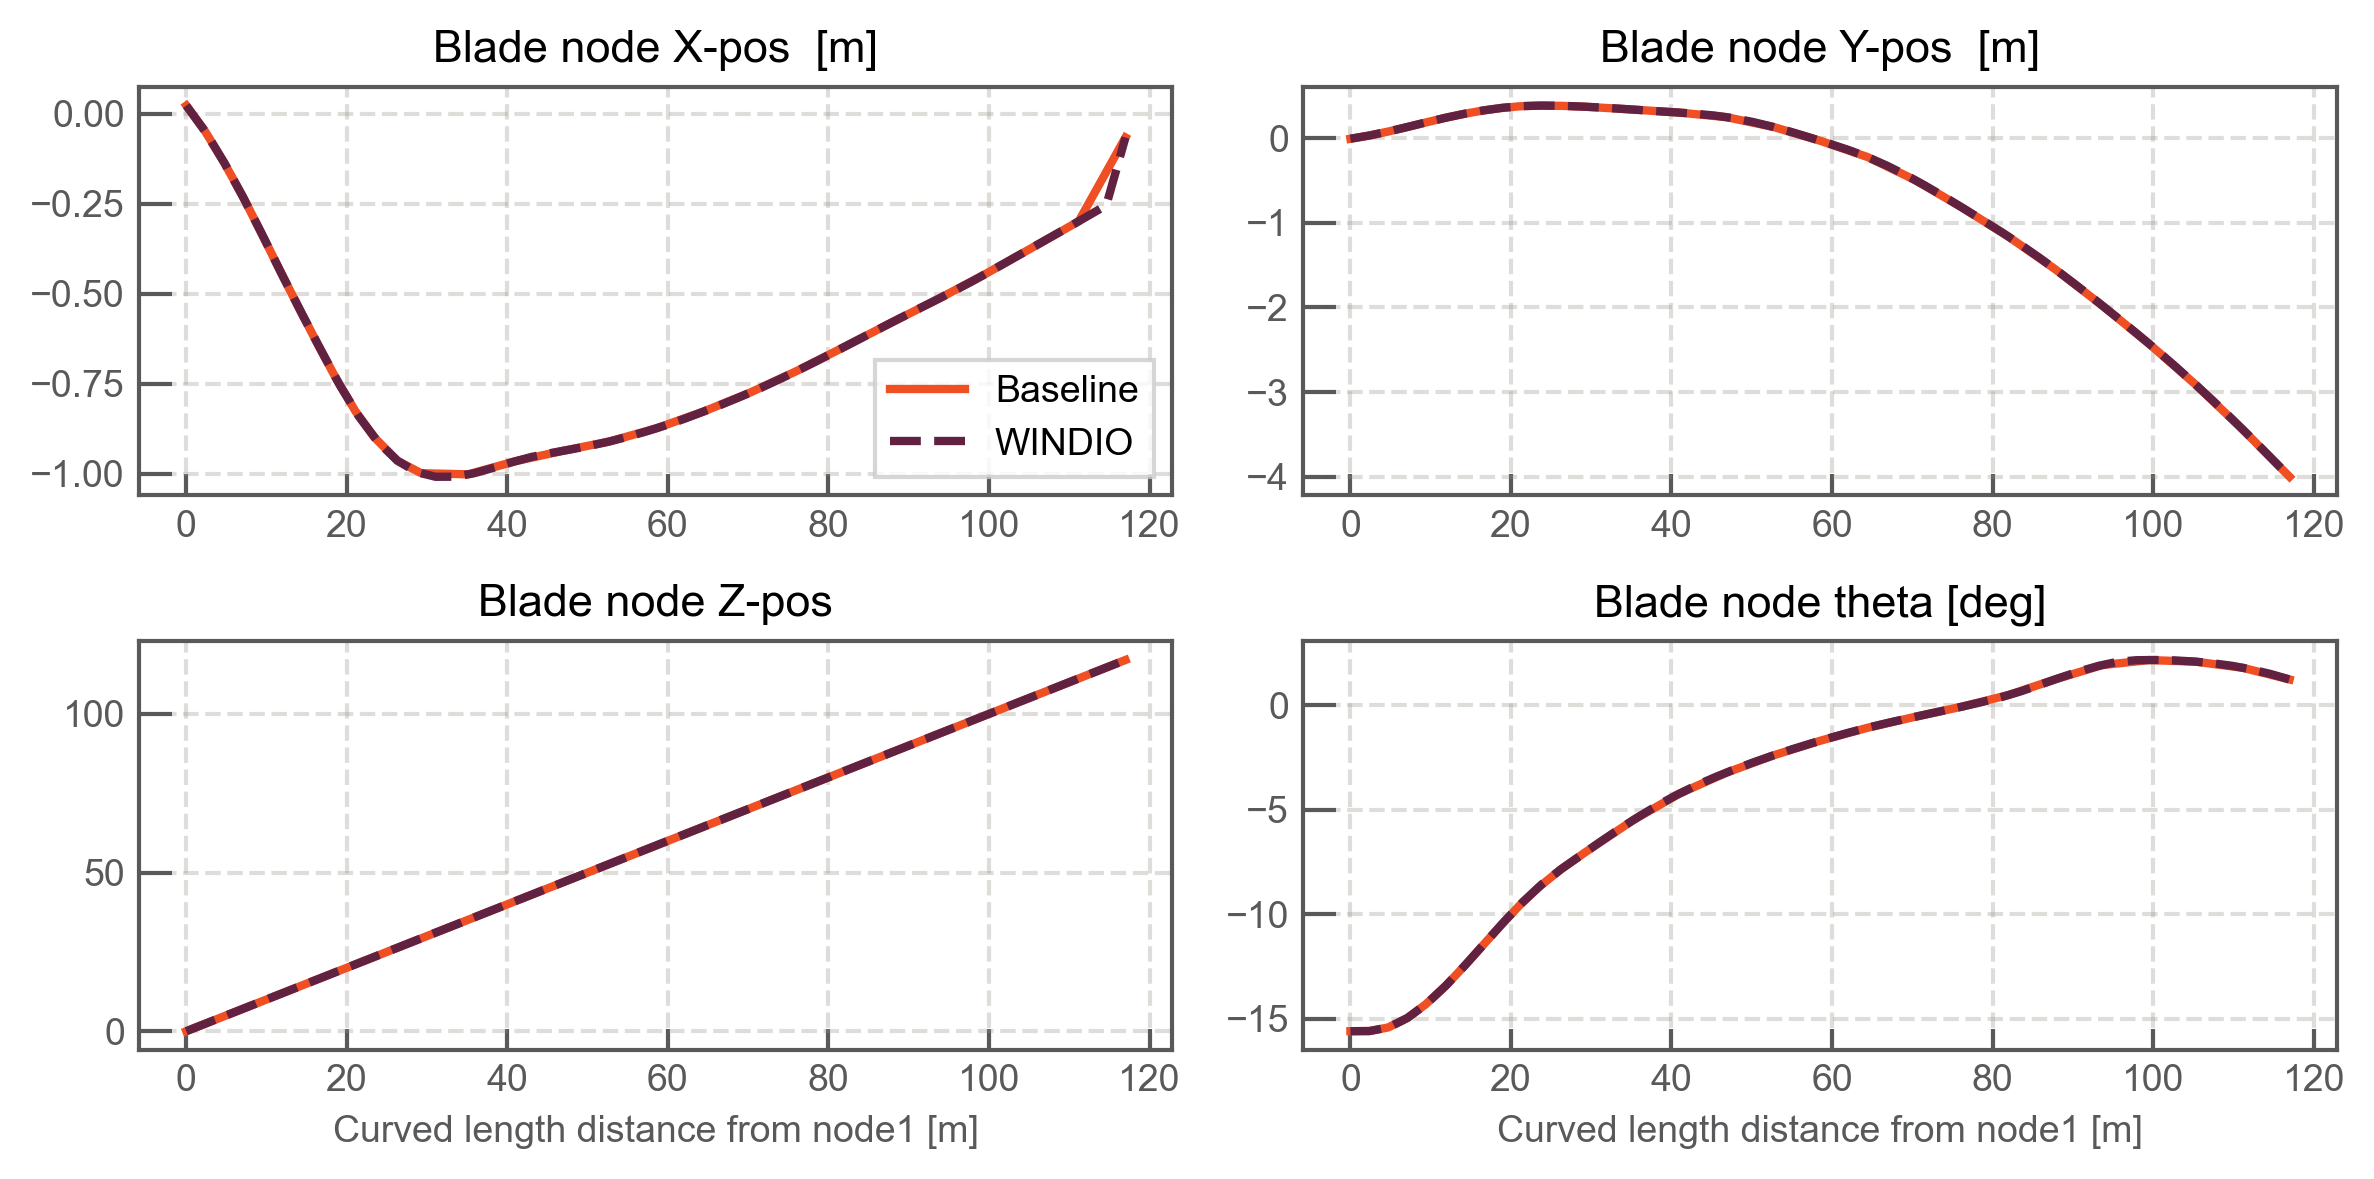

In [17]:
# Number of columns (user-defined)
ncols = 2
# Calculate the number of rows required
nrows = (len(attributes) + ncols - 1) // ncols  # Ceiling division
# Create subplots dynamically based on the number of attributes
fig, axes = plt.subplots(nrows, ncols, figsize=(8,  4))
# Flatten axes array for easier iteration (works for both 1D and 2D cases)
axes = axes.flatten()

# Loop through attributes and create subplots
for i, attr in enumerate(attributes.keys()):
    y_values1 = [sub_array[attr] for sub_array in b1["c2_def"]["sec"]]
    y_values2 = [sub_array[attr] for sub_array in b2["c2_def"]["sec"]]
    axes[i].plot(x_values1, y_values1, label=f"Baseline")
    axes[i].plot(x_values2, y_values2, label=f"WINDIO",linestyle="--")
    axes[i].set_title(f"Blade node {attributes[attr]}")
    #axes[i].legend()
    #axes[i].set_title("Blade node %s"%(attributes[attr][:-5]))
    axes[i].grid(True)

# Hide unused subplots
for i in range(len(attributes), len(axes)):
    axes[i].set_visible(False)

# Add common x-axis label
for ax in axes[-ncols:]:  # Only label the last row
    ax.set_xlabel("Curved length distance from node1 [m]")
axes[0].legend()
# Adjust layout
plt.tight_layout()

create_directory(figure_directory)
filename = "blade_nodal_pos.png"
plt.savefig(os.path.join(figure_directory,filename))

# plt.show()
plt.show()

In [14]:
Ix = iea15_H2_dict1["st"]["blade1"][0][0]["Ix"]
E = iea15_H2_dict1["st"]["blade1"][0][0]["E"]
result_E1 = [ix * e for ix, e in zip(Ix, E)]
Ix2 = iea15_H2_dict2["st"]["blade1"][0][0]["Ix"]
E2 = iea15_H2_dict2["st"]["blade1"][0][0]["E"]
result_E2 = [ix * e for ix, e in zip(Ix2, E2)]
Iy = iea15_H2_dict1["st"]["blade1"][0][0]["Iy"]
E = iea15_H2_dict1["st"]["blade1"][0][0]["E"]
result_Ey1 = [ix * e for ix, e in zip(Ix, E)]
Iy2 = iea15_H2_dict2["st"]["blade1"][0][0]["Iy"]
E2 = iea15_H2_dict2["st"]["blade1"][0][0]["E"]
result_Ey2 = [ix * e for ix, e in zip(Iy2, E2)]
G = iea15_H2_dict1["st"]["blade1"][0][0]["G"]
K = iea15_H2_dict1["st"]["blade1"][0][0]["K"]
result_G1 = [g * k for g, k in zip(G, K)]
G2 = iea15_H2_dict2["st"]["blade1"][0][0]["G"]
K2 = iea15_H2_dict2["st"]["blade1"][0][0]["K"]
result_G2 = [g * k for g, k in zip(G2, K2)]
A1 = iea15_H2_dict1["st"]["blade1"][0][0]["A"]
result_EA1 = [e * a for e, a in zip(E, A1)]
A2 = iea15_H2_dict2["st"]["blade1"][0][0]["A"]
result_EA2 = [e * a for e, a in zip(E2, A2)]

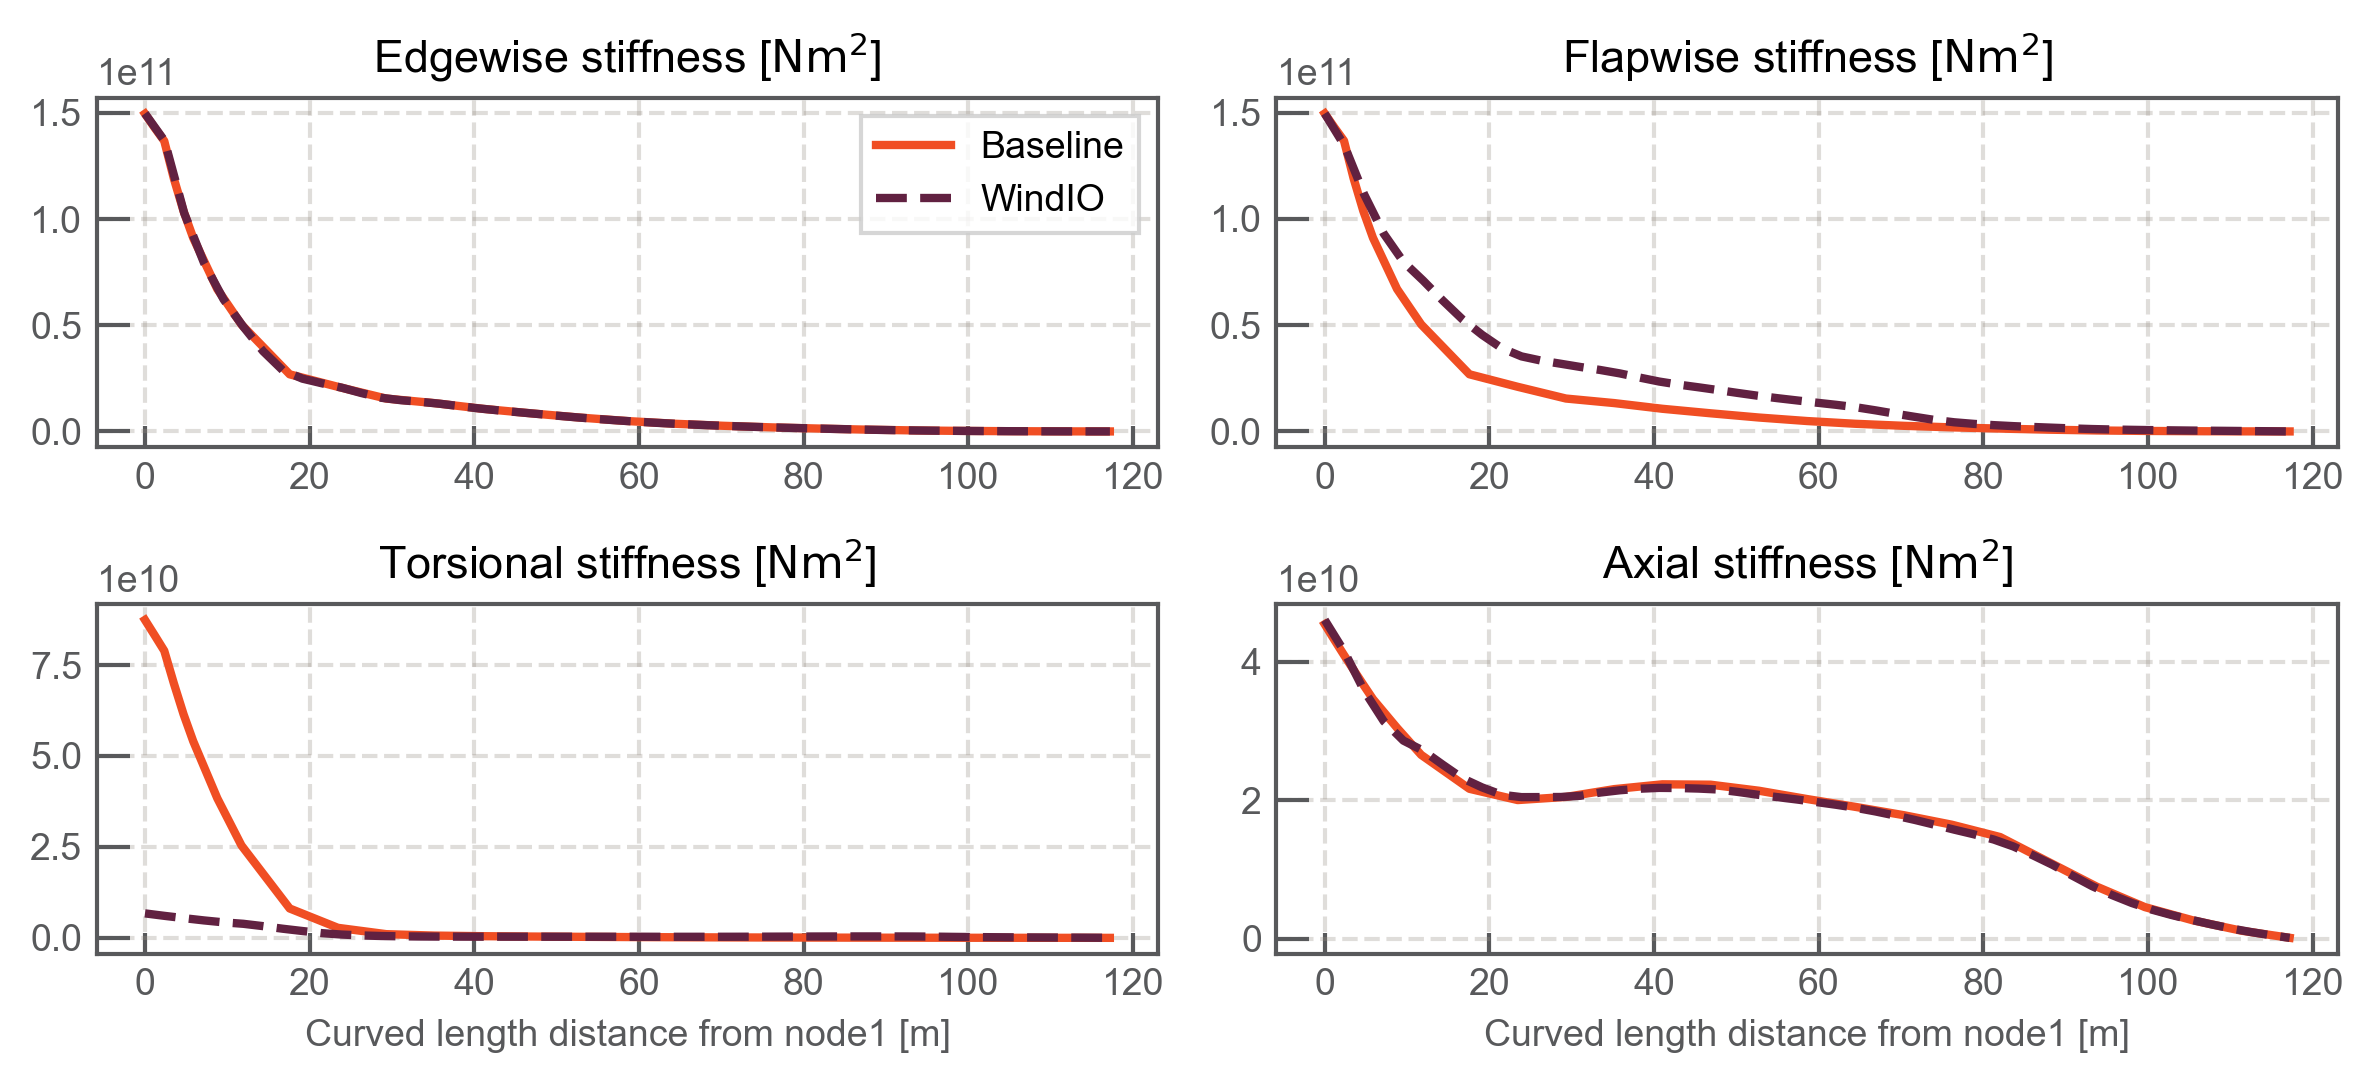

In [16]:
fig,axes = plt.subplots(ncols=2, nrows= 2,figsize= (8,  4))
axes = axes.flatten()
axes[0].plot(iea15_H2_dict1["st"]["blade1"][0][0]["s"], result_E1, label = "Baseline")
axes[0].plot(iea15_H2_dict2["st"]["blade1"][0][0]["s"], result_E2, label = "WindIO",linestyle="--")
#axes[0].set_ylabel("E x I")
#axes[0].set_xlabel("Curved length distance node1 [m]")
axes[0].set_title("Edgewise stiffness [$\mathrm{Nm}^2$]")
#axes[0].set_xlabel("Curved length distance from node1 [m]")
axes[0].grid(True)
axes[1].plot(iea15_H2_dict1["st"]["blade1"][0][0]["s"], result_Ey1, label = "Baseline")
axes[1].plot(iea15_H2_dict2["st"]["blade1"][0][0]["s"], result_Ey2, label = "WindIO",linestyle="--")
#axes10].set_ylabel("E x I")
#axes[1].set_xlabel("Curved length distance node1 [m]")
axes[1].set_title("Flapwise stiffness [$\mathrm{Nm}^2$]")
axes[1].grid(True)
#axes[1].set_xlabel("Curved length distance from node1 [m]")
axes[2].plot(iea15_H2_dict1["st"]["blade1"][0][0]["s"], result_G1, label = "Baseline")
axes[2].plot(iea15_H2_dict2["st"]["blade1"][0][0]["s"], result_G2, label = "WindIO",linestyle="--")
#axes[2].set_ylabel("G x K")
#axes[2].set_xlabel("Curved length distance node1 [m]")
axes[2].set_title("Torsional stiffness [$\mathrm{Nm}^2$]")
axes[2].grid(True)
axes[2].set_xlabel("Curved length distance from node1 [m]")
axes[3].plot(iea15_H2_dict1["st"]["blade1"][0][0]["s"], result_EA1, label = "Baseline")
axes[3].plot(iea15_H2_dict2["st"]["blade1"][0][0]["s"], result_EA2, label = "WindIO",linestyle="--")
#axes[2].set_ylabel("G x K")
#axes[2].set_xlabel("Curved length distance node1 [m]")
axes[3].set_title("Axial stiffness [$\mathrm{Nm}^2$]")
axes[3].grid(True)
axes[3].set_xlabel("Curved length distance from node1 [m]")
# Adjust layout
# Add a shared X-axis label
#fig.text(0.5, 0.04, "Curved length distance from node1 [m]", ha='center')
handles, labels = axes[0].get_legend_handles_labels()  # Get legend info from the first plot
#fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=10)
axes[0].legend()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
create_directory(figure_directory)
filename = "blade_elastic_products.png"
plt.savefig(os.path.join(figure_directory,filename))
# plt.show()
plt.show()

In [64]:
iea15_H2_dict1

HAWC2_dict{htc,htc_filename,ae,pc,st}

In [18]:
body = "blade1"

In [19]:
x_values1 = iea15_H2_dict1["st"][body][0][0]["s"]
x_values2 = iea15_H2_dict2["st"][body][0][0]["s"]
attributes = {
    "m": "m, mass per unit length [kg/m]",
    "A": "A, cross sectional area [$\mathrm{m}^2$]",
    "pitch": "structural pitch [deg]",
    "K": "K, torsional stiffness constant",
    "x_cg": "x_cg, x-coo. of mass cntr [m]",
    "y_cg": "y_cg, y-coo. of mass cntr [m]",
    "ri_x": "ri_x, x-radius of gyration [m]",
    "ri_y": "ri_y, y-radius of  gyration [m]",
    "x_sh": "x_sh, x-coo.  of  shear cntr [m]",
    "y_sh": "y_sh, y-coo. of shear cntr [m]",
    "Ix": "Ix, area moment of inertia [$\mathrm{m}^4$]",
    "Iy": "Iy, area moment  of inertia [$\mathrm{m}^4$]",
    "kx": "kx, x-shear factor",
    "ky": "ky, y-shear factor",
    "xe": "xe, x-coo. of cntr of elast. [m]",
    "ye": "ye, y-coo. of cntr of elast. [m]",
    "E":  "E, modulus  of elast. [$\mathrm{N/m}^2$]",
    "G": "G, shear modulus of elast. [$\mathrm{N/m}^2$]",
    }

In [20]:
x_report = [0,12.9582,
25.9164,
38.8746,
51.8328,
64.791 ,
77.7492,
90.7074,
103.6656,
116.6238,
129.582,]
tower_report = [20287.02772,20287.02772,
20242.37949,
20183.26353,
7297.912906,
6522.583989,
5753.185825,
5027.768286,
4352.106256,
3793.218828,
3818.304546]

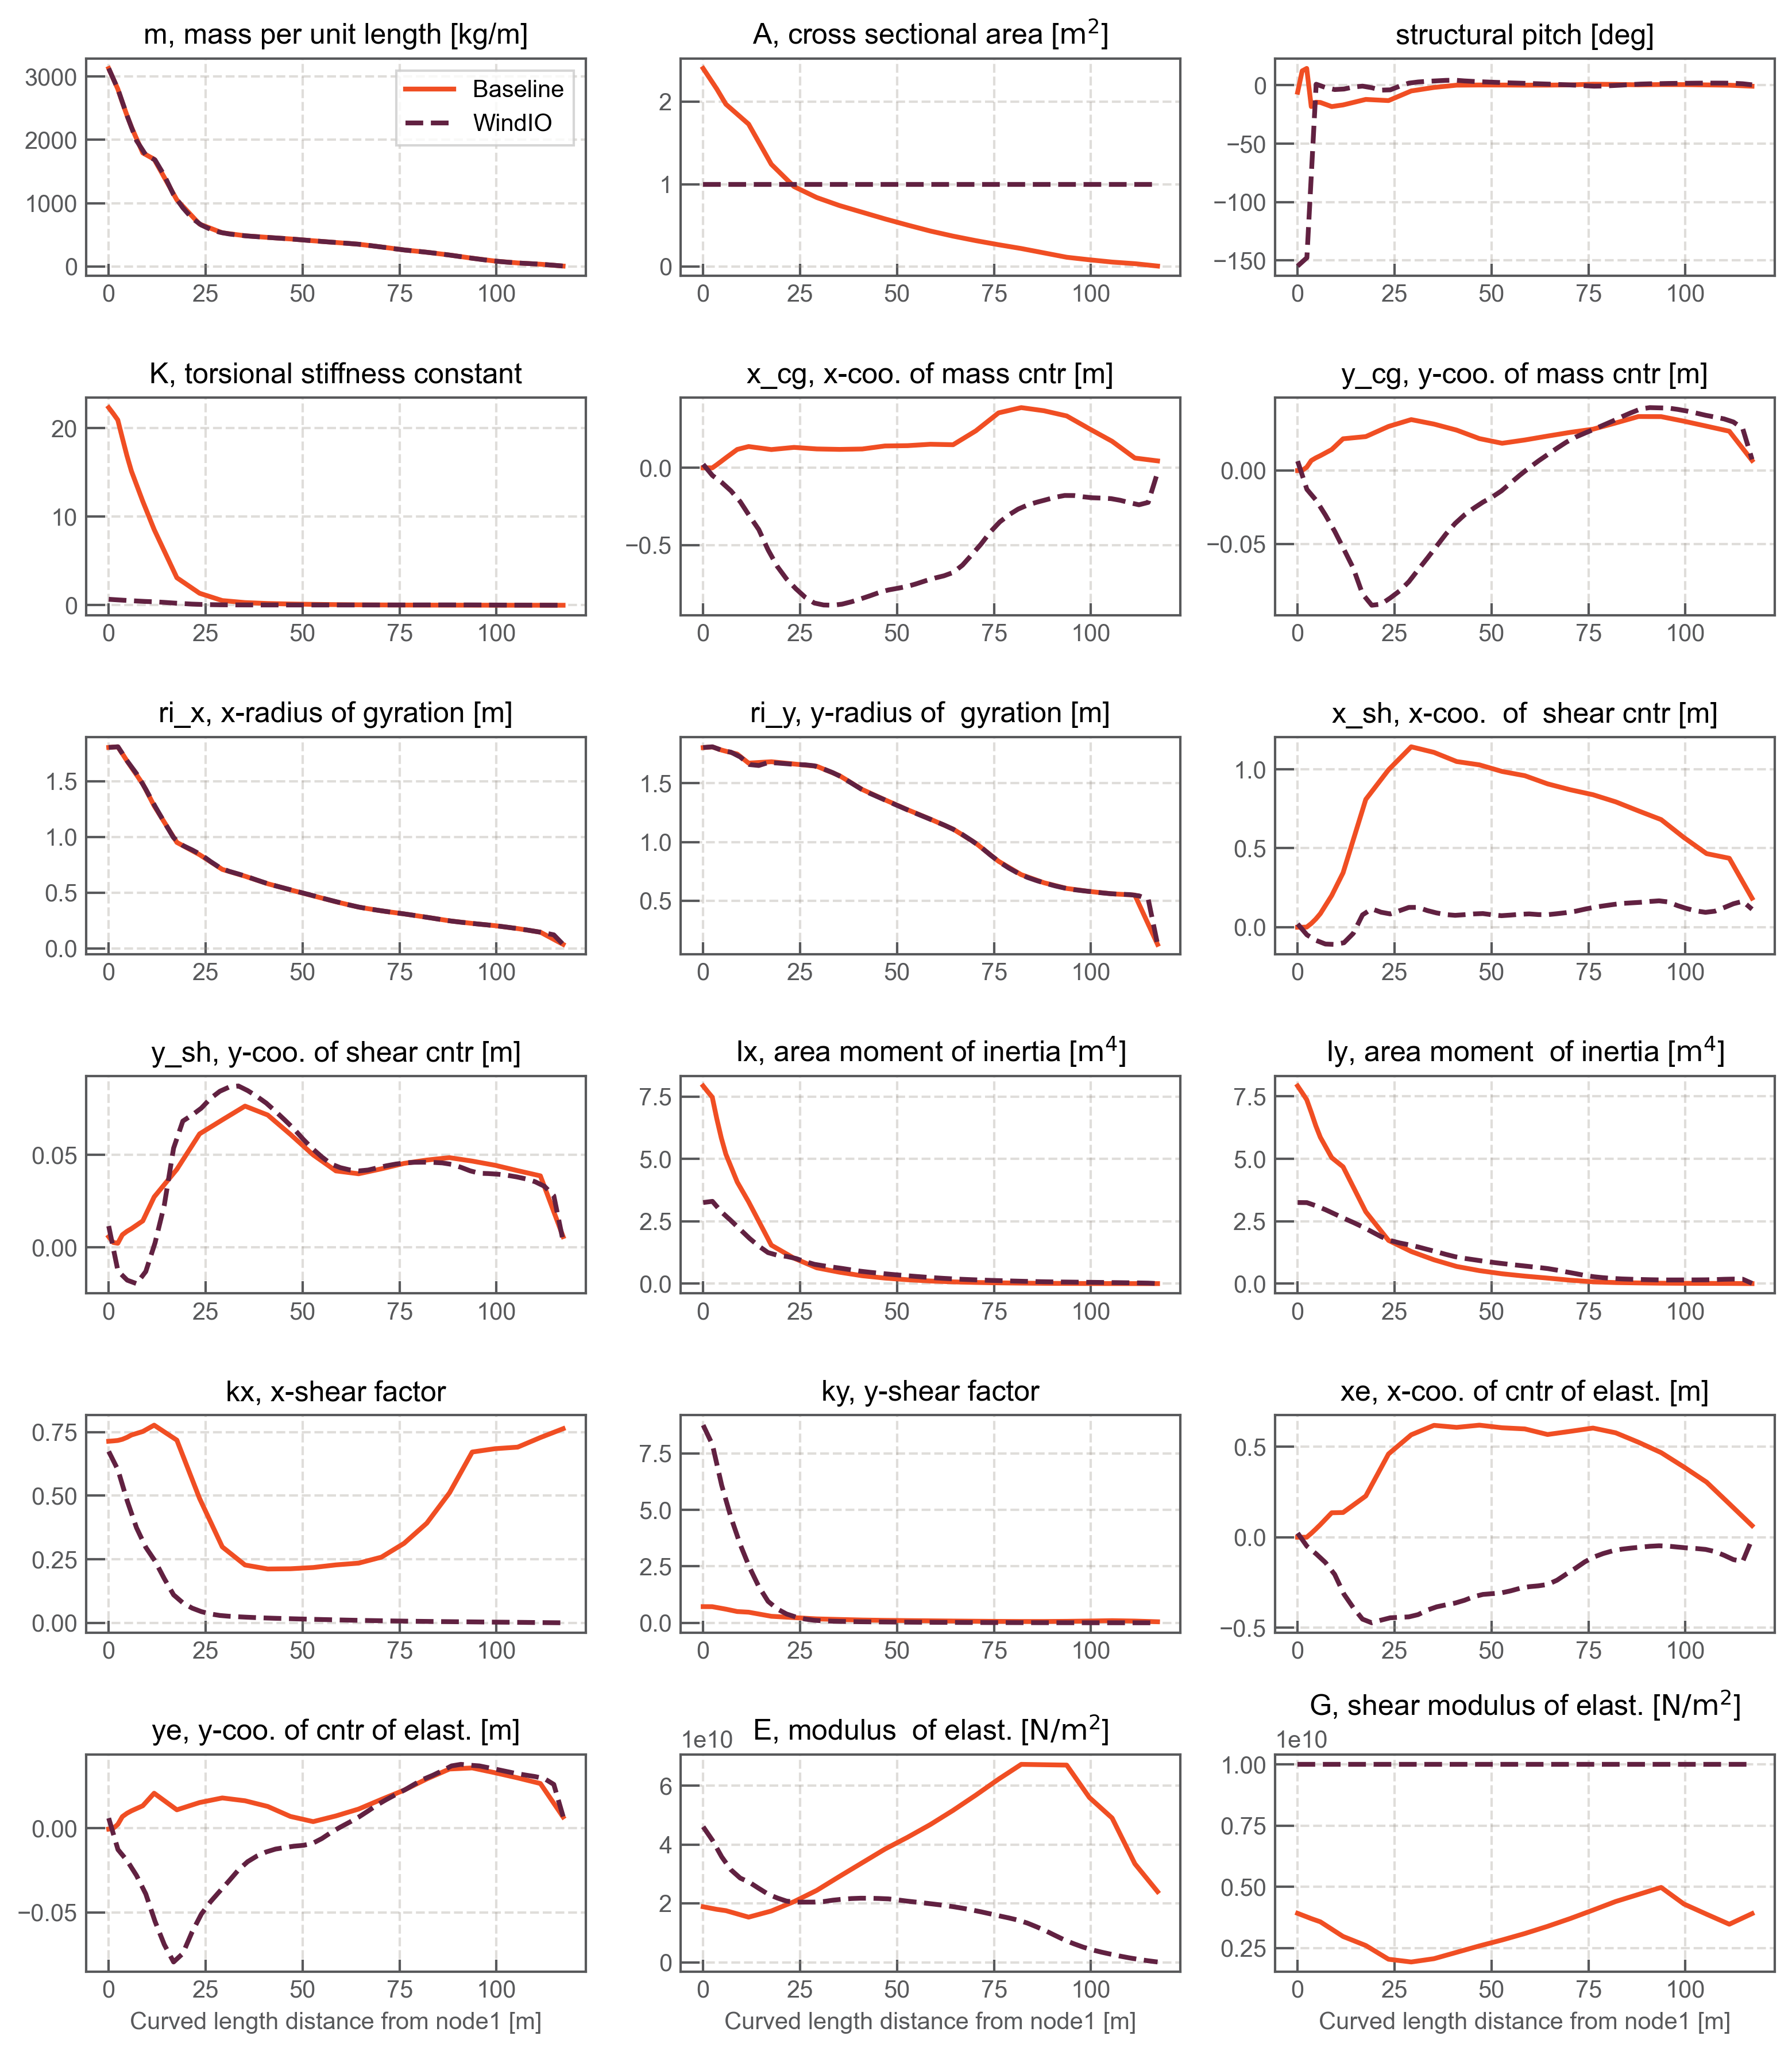

In [21]:
plt.rcParams.update({
    'font.size': 10,         # Set default font size
})
# Number of columns (user-defined)
ncols = 3
# Calculate the number of rows required
nrows = (len(attributes) + ncols - 1) // ncols  # Ceiling division
# Create subplots dynamically based on the number of attributes
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3.5, nrows * 2))
# Flatten axes array for easier iteration (works for both 1D and 2D cases)
axes = axes.flatten()

# Loop through attributes and create subplots
for i, attr in enumerate(attributes.keys()):
    y_values1 = iea15_H2_dict1["st"][body][0][0][attr]
    y_values2 = iea15_H2_dict2["st"][body][0][0][attr]
    # if attr == "m":
    #     axes[i].plot(x_report, tower_report,label=f"Report")
    axes[i].plot(x_values1, y_values1, label=f"Baseline")
    axes[i].plot(x_values2, y_values2, label=f"WindIO",linestyle="--")
    axes[i].set_title(attributes[attr])#,fontsize=12
    #axes[i].set_ylabel(attributes[attr])
    #axes[i].set_xlabel("Curved length distance from node1 [m]")
    #axes[i].set_xlim(0,120)
    #axes[i].legend()
    axes[i].grid(True)
# Only set x-axis labels on the bottom row
# for i, ax in enumerate(axes):
#     if i >= (nrows - 1) * ncols:  # Bottom row
#         ax.set_xlabel("Curved length distance from node1 [m]")
#     else:
#         ax.set_xlabel("")
# Hide unused subplots
for i in range(len(attributes), len(axes)):
    axes[i].set_visible(False)

handles, labels = axes[0].get_legend_handles_labels()  # Get legend info from the first plot
axes[0].legend()
#fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=16)
# Add common x-axis label
for ax in axes[-ncols:]:  # Only label the last row
    ax.set_xlabel("Curved length distance from node1 [m]")
#fig.suptitle("%s: Beam cross-section stiffness and mass properties"%(body),fontsize=16) 
#Adjust layout
plt.tight_layout()#rect=[0, 0, 1, 0.95]
create_directory(figure_directory)
filename = "%s_beam_CS_mass_properties.png"%(body)
plt.savefig(os.path.join(figure_directory,filename))
plt.show()
#plt.close()

## Explore body output

In [21]:
manual_file = "Manual_conversion_IEA15MW/HAWC2/IEA-15-240-RWT-UMAINESEMI/bodyeig/iea_15mw_rwt_manual_body.dat"
windio_file = "WINDIO_conversion_IEA15MW/IEA15MW_Floating/bodyeig/iea_15mw_rwt_windio_body.dat"
manual_data=parse_dat_file(manual_file)
windio_data=parse_dat_file(windio_file)

In [22]:
mapping = {
    "tower": "tower_*",
    "blade1_*" : "blade1_*",
    "towertop" : "towertop",
    "connector" : "connector",
    "shaft" : "shaft",
    "ifb" : ["main_column","column*","y_pontoon_upper*","y_pontoon_lower*"],
    "hub1" : "hub1",
    
}

In [23]:
comparison = compare_properties(manual_data,windio_data,mapping)
comparison_df = comparison_to_dataframe(comparison)
comparison_df.to_excel("compare_bodies.xlsx",index=False,sheet_name="compare_bodies")